In [1]:
from data_utils import dataloader
from model import BillNet
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from import_dataloader_and_class_weights import import_data_loaders_and_class_weights


## Read in and prepare data

In [2]:
train_dataloader, valid_dataloader, class_weights = import_data_loaders_and_class_weights(
    path_text_directory='./data/bert_train_103-114.pt',
    path_label_directory='./data/labels_train_103-114.pt',
    colab_text_file_id='1IZPbb7KEc9fjAItPf1JrPw5Je1Q0woNa',
    colab_label_file_id='1hvyLUS6e9tI_ICietdKUy4XCwurr6lSU'
)

## CNN for the N x S x K embeddings

In [23]:
#Define network, optimizer and criterion
net = BillNet(num_classes = 2)
net = net.cuda()

optimizer = optim.Adam(net.parameters(), lr=0.001, 
                       weight_decay=0.01)
criterion = nn.CrossEntropyLoss(weight=class_weights.cuda())
#criterion = nn.CrossEntropyLoss(weight=class_weights)
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

print(net)

BillNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6624, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=2, bias=True)
)


In [24]:
max_epochs = 6
train_acc = []
losses = []
val_recall_scores = []
# Loop over epochs
for epoch in range(max_epochs):
    # Training
    train_preds, train_targs = [], []
    cur_loss = 0.0
    net.train()
    training_loop = tqdm(iter(train_dataloader), leave=True)
    for local_batch, local_labels in training_loop:
        # Zero gradient
        optimizer.zero_grad()
        # Transfer to GPU
        local_batch = local_batch.to(device, dtype=torch.float)
        local_labels = local_labels.to(device, dtype=torch.long)
        # zero the parameter gradients
       
        # Model computations
        output = net(local_batch)
        batch_loss = criterion(output, local_labels)
        batch_loss.backward()
        optimizer.step()
        training_loop.set_description(f'Epoch {epoch+1}')
        training_loop.set_postfix(loss=batch_loss.item())
        cur_loss += batch_loss
        # Get predictions
        predicted = torch.max(output, 1)[1]
        train_targs += list(local_labels.cpu().numpy())
        train_preds += list(predicted.data.cpu().numpy())
    
    print('-----------Training Metrics-----------')
    print('Accuracy: {}'.format(accuracy_score(train_targs, train_preds)))
    print('F1: {}'.format(f1_score(train_targs, train_preds)))
    print('Precision: {}'.format(precision_score(train_targs, train_preds)))
    print('Recall: {}'.format(recall_score(train_targs, train_preds)))
    print('Confusion Matrix:')
    print(confusion_matrix(train_targs, train_preds))

    # Validation
    net.eval()
    val_preds, val_targs = [], []
    probas = []
    with torch.no_grad():
        for local_batch, local_labels in valid_dataloader:
            local_batch = local_batch.to(device, dtype=torch.float)
            local_labels =  local_labels.to(device, dtype=torch.long)
            outputs = net(local_batch)
            predicted = torch.max(outputs.data, 1)[1]
            probas += list(outputs.data.cpu().numpy()[:,1])
            val_targs += list(local_labels.cpu().numpy())
            val_preds += list(predicted.data.cpu().numpy())
    
    lr_fpr, lr_tpr, _ = roc_curve(val_targs, probas)
    print('-----------Validation Metrics-----------')
    print('Accuracy: {}'.format(accuracy_score(val_targs, val_preds)))
    print('F1: {}'.format(f1_score(val_targs, val_preds)))
    print('Precision: {}'.format(precision_score(val_targs, val_preds)))
    print('Recall: {}'.format(recall_score(val_targs, val_preds)))
    print('Confusion Matrix:')
    print(confusion_matrix(val_targs, val_preds))
    print('-' * 66)

Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [01:03<00:00,  4.05it/s, loss=0.0259]


-----------Training Metrics-----------
Accuracy: 0.9151570048309179
F1: 0.39777111015859407
Precision: 0.2636363636363636
Recall: 0.8097731239092496
Confusion Matrix:
[[14691  1296]
 [  109   464]]
-----------Validation Metrics-----------
Accuracy: 0.9942042984786283
F1: 0.9148936170212766
Precision: 0.9280575539568345
Recall: 0.9020979020979021
Confusion Matrix:
[[3988   10]
 [  14  129]]
------------------------------------------------------------------


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [01:08<00:00,  3.76it/s, loss=0.142]


-----------Training Metrics-----------
Accuracy: 0.9861111111111112
F1: 0.81629392971246
Precision: 0.7525773195876289
Recall: 0.8917975567190227
Confusion Matrix:
[[15819   168]
 [   62   511]]
-----------Validation Metrics-----------
Accuracy: 0.9804395073653707
F1: 0.7624633431085044
Precision: 0.6565656565656566
Recall: 0.9090909090909091
Confusion Matrix:
[[3930   68]
 [  13  130]]
------------------------------------------------------------------


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [01:11<00:00,  3.61it/s, loss=0.0655]

-----------Training Metrics-----------
Accuracy: 0.985084541062802
F1: 0.8059701492537314
Precision: 0.7328571428571429
Recall: 0.8952879581151832
Confusion Matrix:
[[15800   187]
 [   60   513]]


-----------Validation Metrics-----------
Accuracy: 0.992030910408114
F1: 0.887372013651877
Precision: 0.8666666666666667
Recall: 0.9090909090909091
Confusion Matrix:
[[3978   20]
 [  13  130]]
------------------------------------------------------------------


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [01:16<00:00,  3.37it/s, loss=0.59]

-----------Training Metrics-----------
Accuracy: 0.9892512077294686
F1: 0.8531353135313533
Precision: 0.809076682316119
Recall: 0.9022687609075044
Confusion Matrix:
[[15865   122]
 [   56   517]]


-----------Validation Metrics-----------
Accuracy: 0.9944457860420188
F1: 0.9181494661921707
Precision: 0.9347826086956522
Recall: 0.9020979020979021
Confusion Matrix:
[[3989    9]
 [  14  129]]
------------------------------------------------------------------


Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [01:17<00:00,  3.36it/s, loss=0.134]

-----------Training Metrics-----------
Accuracy: 0.9888285024154589
F1: 0.8494711147274207
Precision: 0.7957317073170732
Recall: 0.9109947643979057
Confusion Matrix:
[[15853   134]
 [   51   522]]


-----------Validation Metrics-----------
Accuracy: 0.9869596715769138
F1: 0.8280254777070064
Precision: 0.7602339181286549
Recall: 0.9090909090909091
Confusion Matrix:
[[3957   41]
 [  13  130]]
------------------------------------------------------------------


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [01:17<00:00,  3.33it/s, loss=0.118]


-----------Training Metrics-----------
Accuracy: 0.9856280193236715
F1: 0.8125984251968504
Precision: 0.7403156384505022
Recall: 0.900523560209424
Confusion Matrix:
[[15806   181]
 [   57   516]]
-----------Validation Metrics-----------
Accuracy: 0.9838203332528375
F1: 0.7938461538461538
Precision: 0.7087912087912088
Recall: 0.9020979020979021
Confusion Matrix:
[[3945   53]
 [  14  129]]
------------------------------------------------------------------


In [25]:
lr_precision, lr_recall, _ = precision_recall_curve(val_targs, probas)

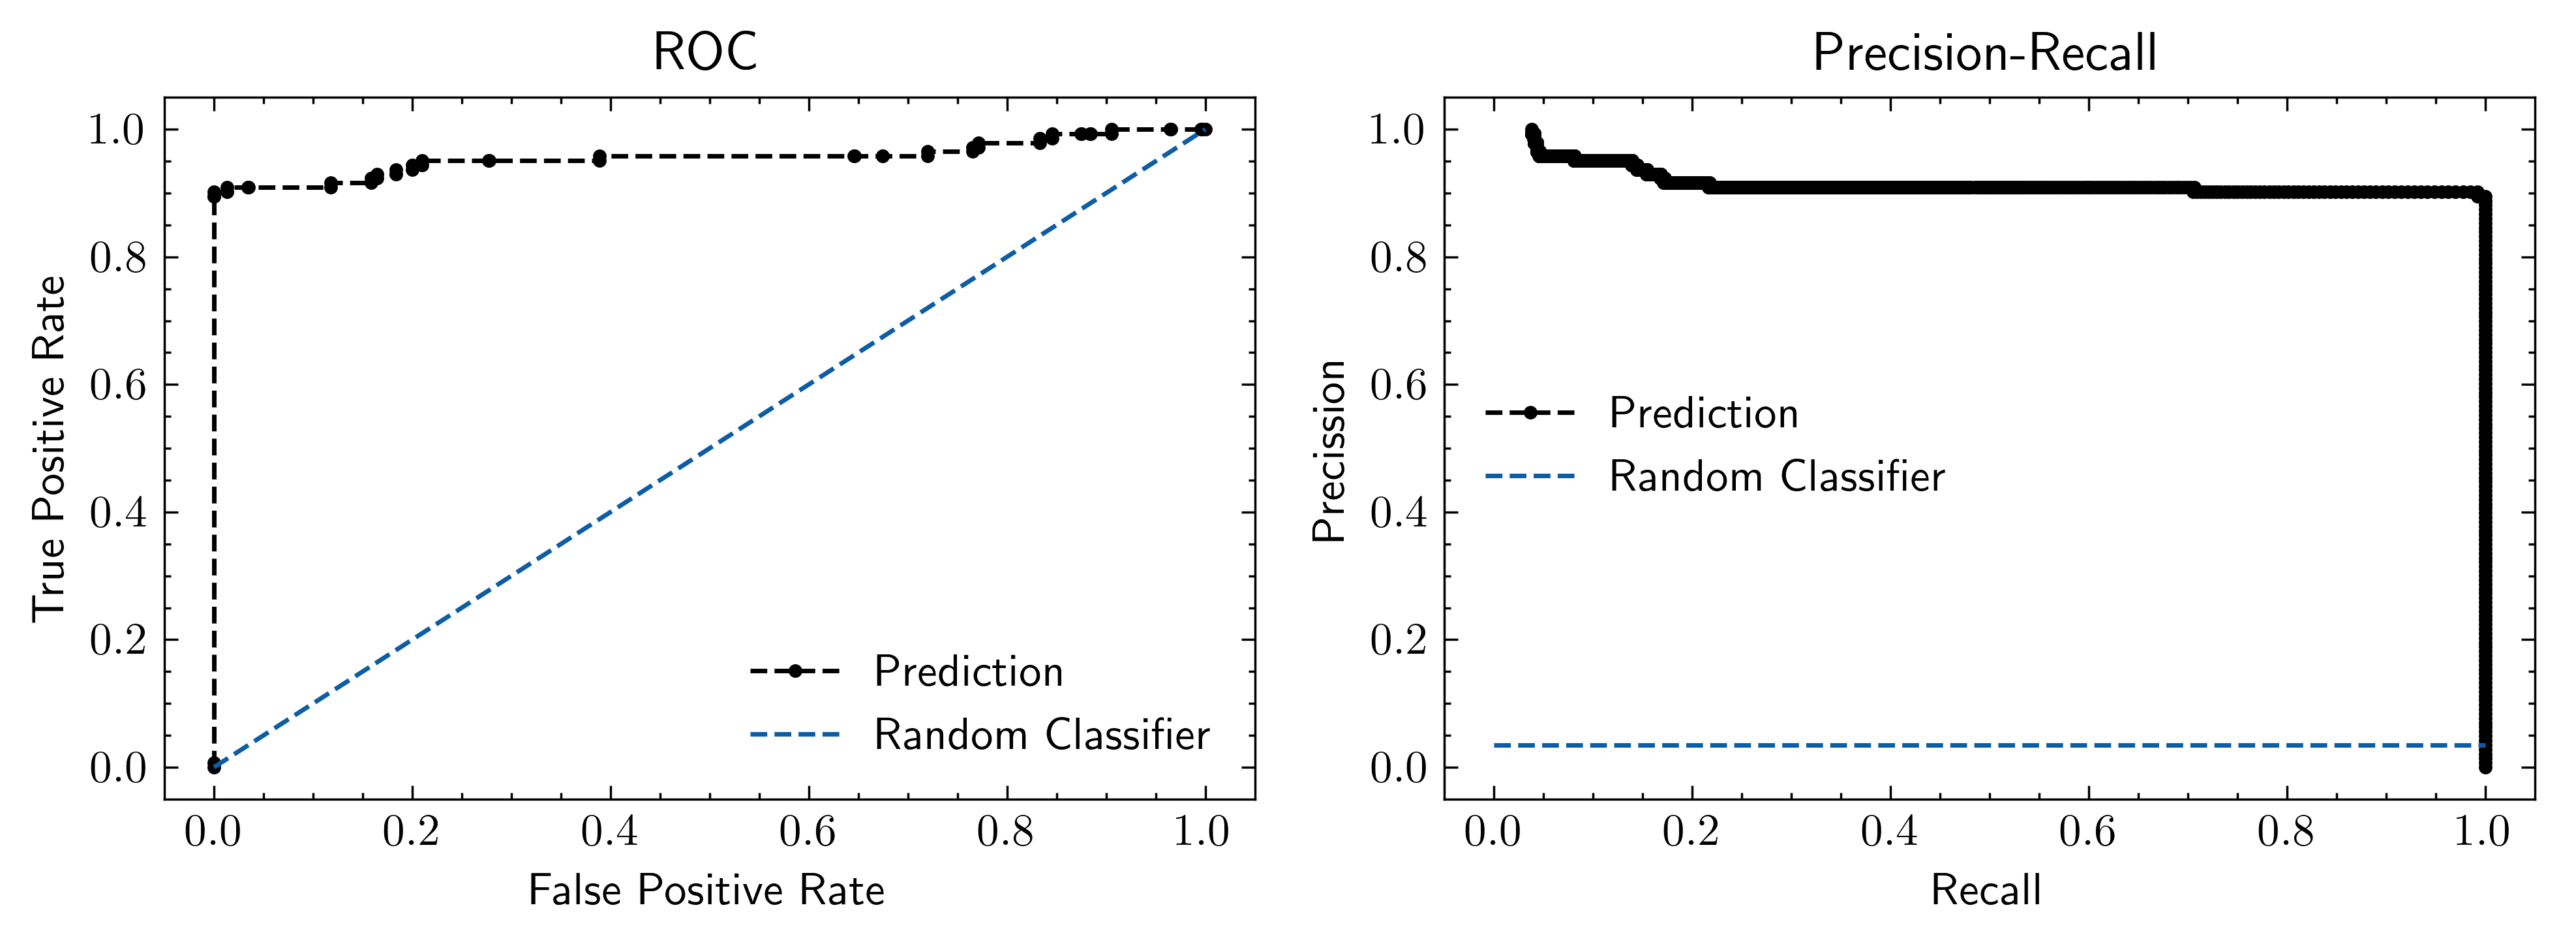

In [26]:

with plt.style.context('science'):
    fig, axs = plt.subplots(ncols = 2, dpi = 500, figsize=(8,3))
    ns_probs = [0 for _ in range(len(val_targs))]
    ns_fpr, ns_tpr, _ = roc_curve(val_targs, ns_probs)
    #with plt.style.context('science'):
    axs[0].plot(lr_fpr, lr_tpr, 'ko--', markersize=2, label='Prediction')
    axs[0].plot(ns_fpr, ns_tpr, linestyle='--', label='Random Classifier')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('ROC')
    axs[0].legend()

    axs[1].plot(lr_precision, lr_recall, 'ko--', markersize=2, label='Prediction')
    no_skill = len([t for t in val_targs if t ==1]) / len(val_targs)
    axs[1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='Random Classifier')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precission')
    axs[1].set_title('Precision-Recall')
    axs[1].legend()
plt.tight_layout()
plt.savefig('metrics.pdf', format='pdf')

In [36]:
from sklearn.metrics import roc_auc_score


In [28]:
roc_auc_score(train_targs, train_preds)

0.9446009306645418

In [26]:
from sklearn.metrics import confusion_matrix
# Confusion matrix
conf_mat=confusion_matrix(val_targs, val_preds)
print(conf_mat)


[[3928   70]
 [  15  128]]


In [27]:
#torch.save(net.state_dict(), 'trained_model.obj')
#net = Net(num_classes = 2)
#net.load_state_dict(torch.load('trained_model.obj'))

## Test data

In [ ]:
#OLD
#import pandas as pd

#test_dataset = np.load('')
#test_dataset = test_dataset[:,None,:, :]
#test_labels = pd.read_pickle('data/processed/test_dat.pkl')
#bill_status = pd.read_csv('data/processed/bill_status.csv').rename({'bill':'bill_id'}, axis=1)
#test_labels = test_labels.merge(bill_status, on = 'bill_id', how='left')['status'].to_numpy()

In [30]:
test_dataset = torch.load('data/processed/bert_test_115.pt')
test_labels = torch.load('data/processed/labels_test_115.pt')

In [31]:
test_dataloader = dataloader(test_dataset, test_labels, batch_size=64)

In [32]:
#test_labels = pd.read_pickle('data/processed/test_dat.pkl')
#test_labels

In [33]:
net.eval()
test_preds, test_targs = [], []
with torch.no_grad():
    for local_batch, local_labels in test_dataloader:
        local_batch = local_batch.to(device, dtype=torch.float)
        local_labels =  local_labels.to(device, dtype=torch.long)
        outputs = net(local_batch)
        predicted = torch.max(outputs.data, 1)[1]
        test_targs += list(local_labels.cpu().numpy())
        test_preds += list(predicted.data.cpu().numpy())
print('-----------Test Metrics-----------')
print('Accuracy: {}'.format(accuracy_score(test_targs, test_preds)))
print('F1: {}'.format(f1_score(test_targs, test_preds)))
print('Precision: {}'.format(precision_score(test_targs, test_preds)))
print('Recall: {}'.format(recall_score(test_targs, test_preds)))
print(confusion_matrix(test_targs, test_preds))

-----------Test Metrics-----------
Accuracy: 0.9851485148514851
F1: 0.7999999999999999
Precision: 0.8235294117647058
Recall: 0.7777777777777778
[[1351    9]
 [  12   42]]


In [34]:
roc_auc_score(test_targs, test_preds)

0.8855800653594771